This notebook is used to generate stats and figures for the 2024-03-22 meeting with the Memento staff.
It contains : summary population statistics, 

In [1]:
from init_nb import init_notebook
config = init_notebook()

import pandas as pd
from pathlib import Path
import joblib

from bold_dementia.data.memento import Memento
from bold_dementia.connectivity.atlases import Atlas

BIDSDIR = Path(config["bids_dir"])

dd = Path(config["data_dir"])
#ORIG_PATH = dd / "phenotypes.tsv"
MERGED_PATH = dd / "output" / "merged_phenotypes.csv"
#SUITE_PATH = dd / "data_memento_suite.txt"

PPATH = Path(config["suite_phenotypes"])

memento = Memento(
        BIDSDIR,
        PPATH,
        atlas=Atlas.from_name("gillig", False),
        augmented_phenotypes=False,
        merged_phenotypes=False
    )
phenotypes = Memento.load_phenotypes(MERGED_PATH, merged=True, augmented=False)

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
res = memento[0]

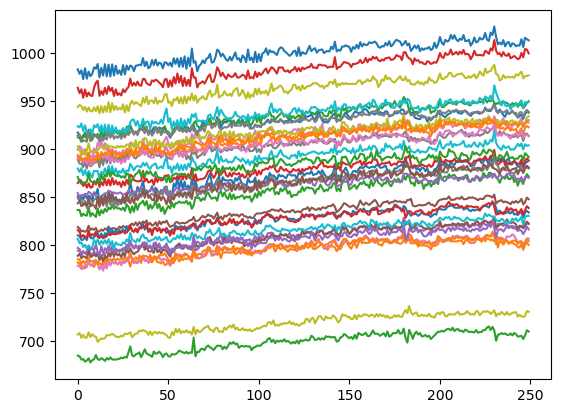

In [8]:
import matplotlib.pyplot as plt
plt.plot(res[0])
plt.show()

In [44]:
#tested_pop = Path(
#    '/bigdata/jlegrand/data/Memento/output/statresults/atlas-gillig-regions_default_ols-cenanom-block/tested_population.csv',
#    )
#df = pd.read_csv(tested_pop, index_col=0)
df = memento.rest_dataset.groupby("sub").sample(n=1)
print("n unique subjects = ", len(df["NUM_ID"].unique()))

n unique subjects =  369


In [36]:
n_missing = len(phenotypes["NUM_ID"].unique()) - len(df["NUM_ID"].unique())
print(f"{n_missing} subjects dropped when joining with scans")

1243 subjects dropped when joining with scans


In [37]:
df["converter"] = (~df.DEMENCE_DAT.isna())
df[">=BAC"] = (df.NIVETUD.isin([">BAC", "BEP, CAP, BAC"]))
cols = ["AGE_CONS", "SEX", ">=BAC", "converter"]
desc = df.loc[:, cols].describe(include="all")
desc.loc['percentage', :] = (desc.loc["freq", :] / len(df)) * 100
desc

,AGE_CONS,SEX,>=BAC,converter
count,369.000000,369,369,369
unique,NaN,2,2,2
top,NaN,Féminin,True,False
freq,NaN,229,290,314
mean,70.088889,NaN,NaN,NaN
std,8.770811,NaN,NaN,NaN
min,34.500000,NaN,NaN,NaN
25%,65.300000,NaN,NaN,NaN
50%,70.800000,NaN,NaN,NaN
75%,76.000000,NaN,NaN,NaN


In [5]:
groupdesc = df.loc[:, cols].groupby("converter").describe(include="all").loc[:, ">=BAC"]
groupdesc.loc[:, "percentage"] = (groupdesc.loc[:, "freq"] / groupdesc.loc[:, "count"]) * 100
groupdesc

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,percentage
converter,,,,,,,,,,,,
False,2535,2,True,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.698225
True,389,2,True,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.437018


In [6]:
ss = df.groupby("sub").sample(n=1)

In [7]:
ss.columns.to_list()

['file_path',
 'file_basename',
 'file_tag',
 'file_type',
 'file_fields',
 'sub',
 'ses',
 'task',
 'space',
 'res',
 'desc',
 'CEN_ANOM',
 'NUM_ID',
 'SEX',
 'INCCONSDAT_D',
 'AGE_CONS',
 'NIVETUD',
 'MCI',
 'CDRSCR',
 'MA',
 'DEMENCE_DAT',
 'APOE_eps4',
 'APOE_geno',
 'APOE_y',
 'M000',
 'M024',
 'M048',
 'current_scan_age',
 'scan_to_onset',
 'converter',
 '>=BAC']

In [8]:
from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Logit
import numpy as np
msk = (~ss.DEMENCE_DAT.isna()) & (ss.MA == 0)
testset = ss[~msk]
testset.loc[:,"converter"] = np.where(testset.DEMENCE_DAT.isna(), 0, 1)
#model = Logit.from_formula("converter ~ scale(AGE_CONS) + C(SEX) + NIVETUD", data=testset)
model = Logit.from_formula(
    "converter ~ scale(AGE_CONS) + C(SEX, Treatment(reference='Masculin')) + Q('>=BAC')",
    data=testset
)
res = model.fit(maxiter=500)
print("Parameters: ", res.params)

Optimization terminated successfully.
         Current function value: 0.346138
         Iterations 7
Parameters:  Intercept                                            -1.585322
C(SEX, Treatment(reference='Masculin'))[T.Féminin]   -0.386430
Q('>=BAC')[T.True]                                   -0.408826
scale(AGE_CONS)                                       0.515392
dtype: float64


In [9]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converter   No. Observations:                 1388
Model:                          Logit   Df Residuals:                     1384
Method:                           MLE   Df Model:                            3
Date:                Wed, 20 Mar 2024   Pseudo R-squ.:                 0.04325
Time:                        10:48:03   Log-Likelihood:                -480.44
converged:                       True   LL-Null:                       -502.16
Covariance Type:            nonrobust   LLR p-value:                 1.993e-09
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             -1.5853      0.203     -7.812      0.000      -1.983      -1.188
C(SEX, Treatment(reference='Masculin'))[T.Féminin]    -0.3864      0.173     -2.229      0.026      -0.726      -0.047
Q('>=BAC')[T.True]                                    -0.4088      0.189     -2.166      0.030      -0.779      -0.039
scale(AGE_CONS)                                        0.5154      0.098      5.262      0.000       0.323       0.707
======================================================================================================================
"""

In [10]:
res.pvalues # TODO Check residuals

Intercept                                             5.613472e-15
C(SEX, Treatment(reference='Masculin'))[T.Féminin]    2.584281e-02
Q('>=BAC')[T.True]                                    3.029766e-02
scale(AGE_CONS)                                       1.423015e-07
dtype: float64

In [11]:
from nilearn.interfaces.fmriprep import load_confounds

In [12]:
scanidx = 900
fpath = df.iloc[scanidx, 0]
fname = df.iloc[scanidx, 1]
confounds, msk = load_confounds(fpath, strategy=["motion", "wm_csf", "global_signal"], motion="basic")

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


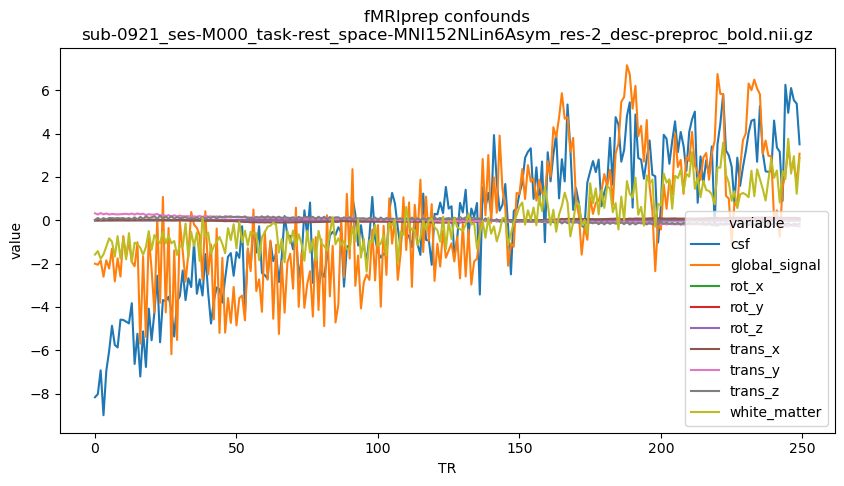

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

confounds["TR"] = list(range(len(confounds)))
m = confounds.melt(id_vars="TR")

plt.subplots(figsize=(10, 5))
sns.lineplot(m, x="TR", y="value", hue="variable")
plt.title(f"fMRIprep confounds\n{fname}")
plt.show()

In [14]:
from bold_dementia.connectivity.atlases import Atlas

atlas = Atlas.from_name("gillig", soft=False)

In [15]:
import nibabel as nib
arr = nib.load(fpath).get_fdata()

In [16]:
import joblib
ts = joblib.load("/georges/memento/BIDS/derivatives/gillig/time_series/sub-1321_ses-M000_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz")

In [17]:
arr.shape

(91, 109, 91, 250)

In [18]:
91 * 109 * 91

902629

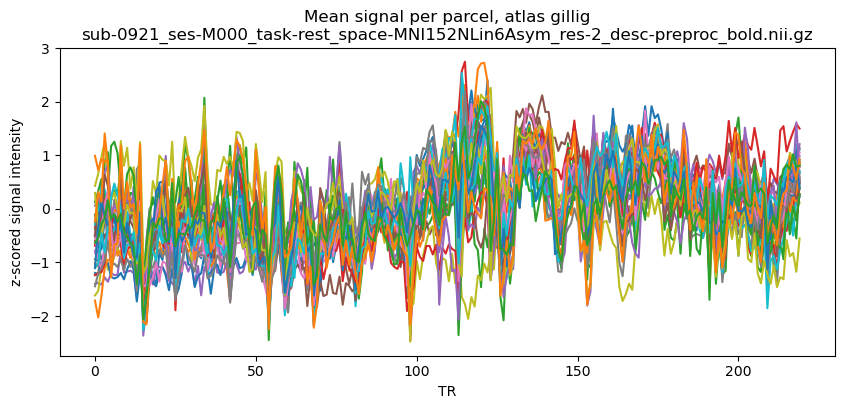

In [19]:
from scipy.stats import zscore
plt.subplots(figsize=(10, 4))
plt.plot(zscore(ts)[10:])
plt.xlabel("TR")
plt.ylabel("z-scored signal intensity")
plt.title(f"Mean signal per parcel, atlas {atlas.name}\n{fname}")
plt.show()


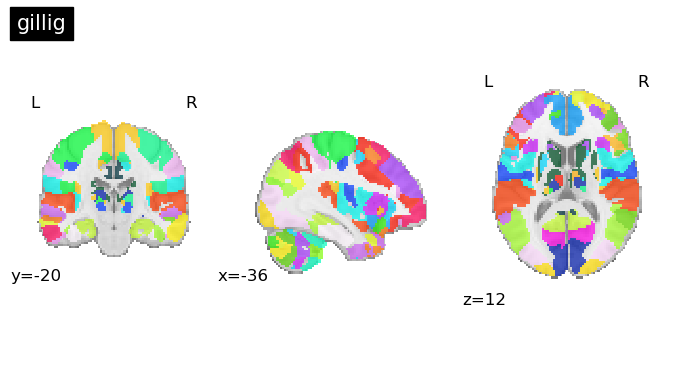

In [20]:
atlas.plot(draw_cross=False)
plt.show()

In [26]:
matrices = joblib.load("/bigdata/jlegrand/data/Memento/output/connectivity/atlas-gillig_default/control.joblib")

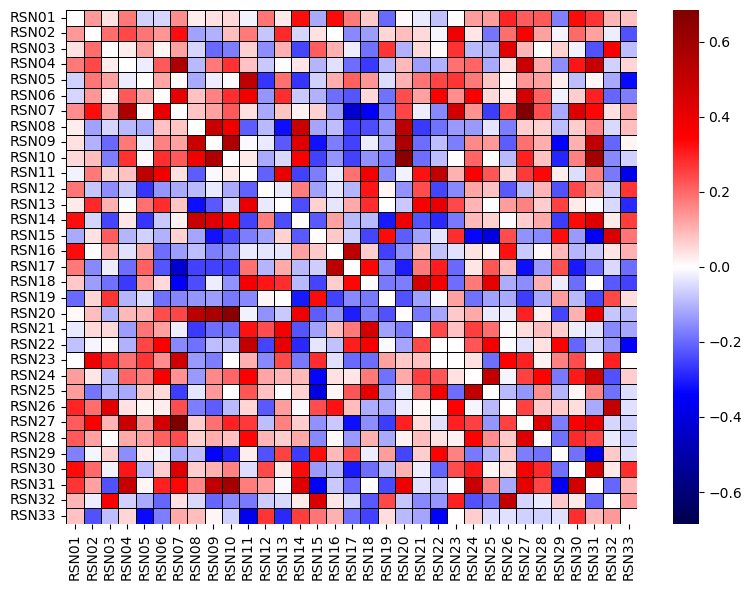

In [30]:
from bold_dementia.connectivity import plot_matrix, plot_ordered_matrix
plot_ordered_matrix(matrices[100, :, :], atlas)
plt.show()